In [8]:
%load_ext autoreload
%autoreload 2

from scipy.signal import blackmanharris, gaussian
from scipy.io import wavfile
import os
import time
import matplotlib.pyplot as plt
from phase_transform import PhaseTransform
from pathlib import Path
import numpy as np
from utils import *
from glob import glob 
from keras.models import load_model
from tqdm import tqdm


sample_rate = 44100
nfft = 2048
freq_bins = nfft//2+1
time_context = 11
num_epochs = 10
f = np.arange(freq_bins)*sample_rate/nfft
t = np.arange(time_context, dtype=float)/sample_rate*nfft
tt = PhaseTransform(frameSize=nfft, hopSize=nfft//4, sampleRate=sample_rate, window=blackmanharris)

sources = ['vocals','bass','drums','other']
models_path = Path("results") / "models"
models = [load_model(models_path / (s+".h5")) for s in sources]
n_sources = len(sources)
channels = ['left', 'right']
n_channels = len(channels)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
features = Path("results/features/valid")
songs = Path("results/sep/valid")
song = "059 - Black Bloc - If You Want Success"

os.makedirs(songs, exist_ok=True)
os.makedirs(songs / song, exist_ok=True)

def reconstitute_song(song, transform=tt, models=[], n_channels=2, time_context=11):
    n_parts = len(glob(f"{song}*.data")) // 4
    n_parts = 2 #FIXME
    n_sources = len(models)
    rec_in = []
    rec_out = []
    
    for i in tqdm(range(n_parts-1)): #FIXME -1 because on an error in compute_features
        mag_in = load_tensor(song + "_" + str(i) + "_in_m_.data", window=(0,time_context,0))
        phs_in = load_tensor(song + "_" + str(i) + "_in_p_.data", window=(0,time_context,0,0))
        ph_in, df_ph_in, dt_ph_in = phs_in[...,0], phs_in[...,1], phs_in[...,2]
        mag_out = load_tensor(song + "_" + str(i) + "_out_m_.data", window=(0,time_context,0))
        phs_out = load_tensor(song + "_" + str(i) + "_out_p_.data", window=(0,time_context,0,0))
        ph_out, df_ph_out, dt_ph_out = phs_out[...,0], phs_out[...,1], phs_out[...,2]
        
        rec_in_parts = None
        rec_out_parts = None
        for j, (k, model) in zip(range(n_channels), enumerate(models)):
            mag_pred = model.predict([mag_in, df_ph_in, dt_ph_in])
            rec_in_part = transform.compute_inverse(mag_pred[:,j,:], 
                                                    ph_in[:,j,0,:])
            rec_out_part = transform.compute_inverse(mag_out[:,k*n_channels+j,0,:], 
                                                     ph_out[:,k*n_channels+j,0,:])
            if rec_out_parts is None:
                rec_in_parts = np.zeros((n_channels*n_sources, len(rec_in_part)))
                rec_out_parts = np.zeros((n_channels*n_sources, len(rec_in_part)))
            rec_in_parts[k*n_channels+j] = rec_in_part
            rec_out_parts[k*n_channels+j] = rec_out_part
        
        rec_in.append(rec_in_parts)
        rec_out.append(rec_out_parts)
    
    return np.concatenate(rec_in, axis=0).T, np.concatenate(rec_out, axis=0).T


reconstructed, original = reconstitute_song(str(features / song),
                                models=models)

100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


In [10]:
def export_song(folder, mix_song, sources=sources, n_channels=n_channels, sample_rate=sample_rate):
    for i, s in enumerate(sources):
        filename = str(folder / (s + ".wav"))
        print(filename)
        wavfile.write(filename, sample_rate, mix_song[:, i*n_channels:(i+1)*n_channels])
    
    
orig_folder = songs / song / "orig"
mss_folder = songs / song / "mss"
os.makedirs(mss_folder, exist_ok=True)
os.makedirs(orig_folder, exist_ok=True)
export_song(mss_folder, reconstructed, sources=sources)
export_song(orig_folder, original, sources=sources)

results/sep/valid/059 - Black Bloc - If You Want Success/mss/vocals.wav
results/sep/valid/059 - Black Bloc - If You Want Success/mss/bass.wav
results/sep/valid/059 - Black Bloc - If You Want Success/mss/drums.wav
results/sep/valid/059 - Black Bloc - If You Want Success/mss/other.wav
results/sep/valid/059 - Black Bloc - If You Want Success/orig/vocals.wav
results/sep/valid/059 - Black Bloc - If You Want Success/orig/bass.wav
results/sep/valid/059 - Black Bloc - If You Want Success/orig/drums.wav
results/sep/valid/059 - Black Bloc - If You Want Success/orig/other.wav


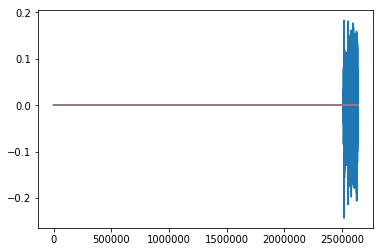

In [7]:
plt.plot(original[:,])